# Assignment 03
Name: Yan Qinlin  
SID: 12231096  
Due: 2022/11/15

In [1]:
import random
from math import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import netCDF4
import xarray as xr
%matplotlib inline
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

**Ref:** All the programming details were referred to the handout of course ESE5023 by professor Zhu (https://zhu-group.github.io/ese5023).

## 1. Global methane levels from 2002

In [12]:
# Open a netCDF4 file
ds1 = xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")

# Show dataset
ds1

<xarray.Dataset>
Dimensions:                  (time: 210, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2003-01-16T12:00:00 ... 20...
  * lat                      (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                      (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] ...
    lat_bnds                 (lat, bnds) float64 ...
    lon_bnds                 (lon, bnds) float64 ...
    pre                      (pressure) float64 ...
    pre_bnds                 (pressure, bnds) float64 ...
    land_fraction            (lat, lon) float64 ...
    xch4                     (time, lat, lon) float32 ...
    xch4_nobs                (time, lat, lon) float64 ...
    xch4_stderr              (time, lat, lon) float32 ...
    xch4_stddev              (time, lat, lon) float32 ...
    column_averaging_kernel  (time, pressure, lat, lon) float32 ...
    vmr_profile_ch4_apriori  (time, pressure, lat, lon) float32 ...
Attributes: (12/28)
    activity_id:            obs4MIPs
    comment:                Since long time, climate modellers use ensemble a...
    contact:                Maximilian Reuter (maximilian.reuter@iup.physik.u...
    Conventions:            CF-1.7 ODS-2.1
    creation_date:          2021-02-05T09:48:47Z
    data_specs_version:     2.1.0
    ...                     ...
    source_version_number:  v4.3
    title:                  C3S XCH4 v4.3
    tracking_id:            892d184a-7b35-4bba-836a-94b9cfeb360e
    variable_id:            xch4
    variant_info:           Best Estimate
    variant_label:          BE

In [13]:
#单位换算，结果为ppb
ds1['xch4'] = ds1['xch4'] * 1000000000

### 1.1

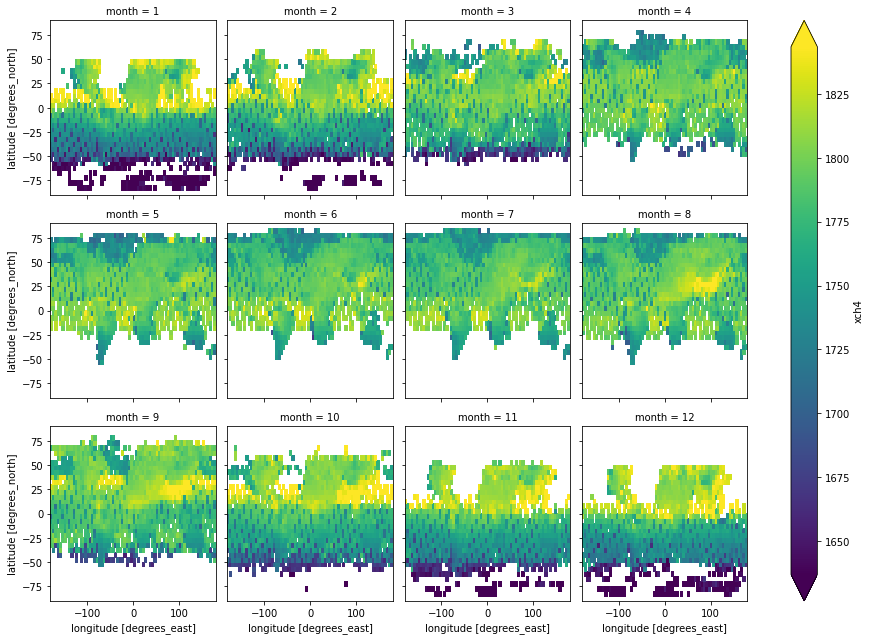

In [14]:
#按月度统计
xch_clim = ds1.groupby('time.month').mean()
# Plot monthly mean, one at a panel
xch_clim.xch4.plot(col="month", col_wrap=4, robust=True)


### 1.2

Text(0.5, 1.0, 'Globally-averaged Methane From 2003-01 to 2020-06')

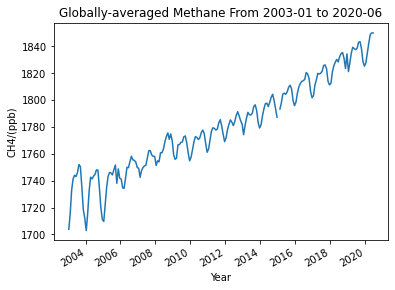

In [15]:
#计算全球的甲烷水平
xch_global = ds1.mean(dim=('lon','lat'))
#画出时间序列图
xch_global.xch4.plot()
plt.ylabel("CH4/(ppb)")
plt.xlabel("Year")
plt.title("Globally-averaged Methane From 2003-01 to 2020-06")

The time series diagram of globally-averagd mehtane has an increase trend as well as a obvious annual periodic fluctuation. Compared to the timeplot of global atmospheric methane by NOAA (detected on marine surface), the data used here (satellite retrieved column-average dry-air mole fraction of atmospheric methane) is little bit lower, the reason of which maybe the impact of atmosphere.



### 1.3

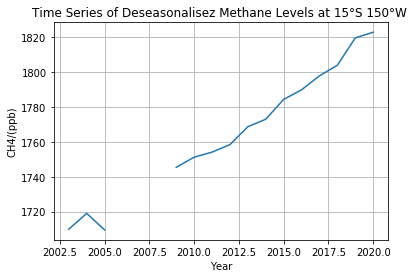

In [88]:
#算年平均就能够去除季节波动，同时选择指定地点画时间序列图
ds1.groupby('time.year').mean().xch4.sel(lon=-150, lat=-15, method='nearest').plot()
plt.ylabel("CH4/(ppb)")
plt.xlabel("Year")
plt.title("Time Series of Deseasonalisez Methane Levels at 15°S 150°W ")
plt.grid()

Some data missed from 2005 to May of 2008 at point(15°S 150°W). There is a obvious growing trend for atmospheric Methane level.

## 2. Niño 3.4 index

In [238]:
# Open a netCDF4 file
ds2 = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")

# Show dataset
ds2

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

### 2.1

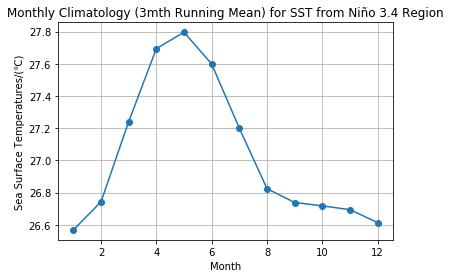

In [218]:
#计算SST在Niño 3.4 区域的climatology，注意经度需要做一个换算
sst_clim = ds2.groupby('time.month').mean().sel(lat=slice(-5,5),lon=slice(190,240)).mean(dim=('lon','lat'))

#画出来climatology
plt.plot(sst_clim.month,sst_clim.sst,'o-')
plt.ylabel("Sea Surface Temperatures/(℃)")
plt.xlabel("Month")
plt.title("Monthly Climatology (3mth Running Mean) for SST from Niño 3.4 Region")
plt.grid()

In [219]:
#把climatology和月平均时间序列都转成dataframe
sst_clim_df = sst_clim.to_dataframe()
month_mean = ds2.sel(lat=slice(-5,5),lon=slice(190,240)).mean(dim=('lon','lat')).to_dataframe()

#都新加一列存月份
sst_clim_df['mon'] = sst_clim_df.index
month_mean['mon'] = month_mean.index.month

#合并两个df
sst_anom = month_mean.merge(sst_clim_df,on='mon')

#重命名
sst_anom.rename(columns={'sst_x':'Origin_data','sst_y':'Climatology'},inplace=True)

#增加新列计算anomalies,并展示
sst_anom['Anomalies'] = sst_anom['Origin_data'] - sst_anom['Climatology']
sst_anom['Anomalies'].head(10)

0   -0.319580
1   -0.191473
2   -0.444782
3   -0.701401
4    0.851555
5   -0.782999
6    1.175951
7   -0.395283
8   -0.792450
9    0.981344
Name: Anomalies, dtype: float32

### 2.2

In [220]:
#生成新列，类型是datetime
sst_anom['Time'] = pd.date_range(start='1960-01',end='2017-01',freq='M')

#对anomaly做3month滑动平均
sst_anom['anom_3mth'] = sst_anom['Anomalies'].rolling(3,center=True).mean()

D:\anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
D:\anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy arra

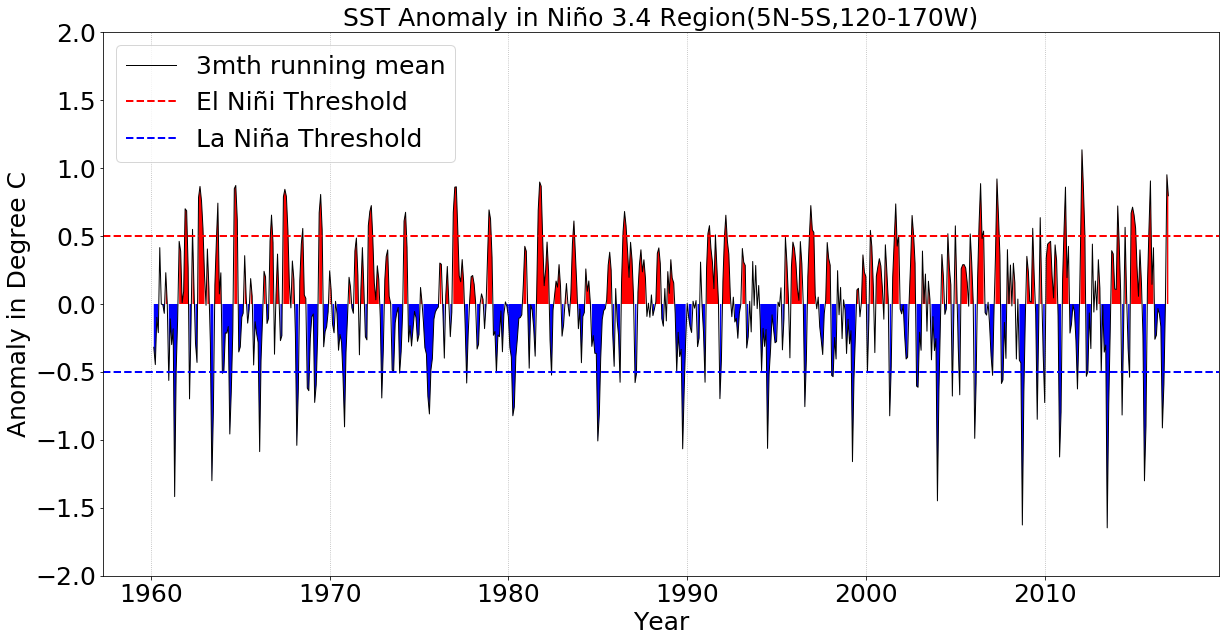

In [236]:
#画出来
fig, ax = plt.subplots(1,1,figsize=(20,10))

#画3mth 线
plt.plot(sst_anom['Time'],sst_anom['anom_3mth'],'-',lw=1,color='k',label='3mth running mean')

#大于0填充红色，小于0填充蓝色
ax.fill_between(sst_anom['Time'],sst_anom['anom_3mth'],facecolor='r',where=sst_anom['anom_3mth']>0)
ax.fill_between(sst_anom['Time'],sst_anom['anom_3mth'],facecolor='b',where=sst_anom['anom_3mth']<0)

#画出厄尔尼诺和拉尼娜的阈值横线
plt.axhline(0.5,color='r',ls='--',lw=2,label='El Niñi Threshold')
plt.axhline(-0.5,color='b',ls='--',lw=2,label='La Niña Threshold')

#else about plotting
plt.ylabel("Anomaly in Degree C",fontsize=25)
plt.ylim(-2,2)
plt.xlabel("Year",fontsize=25)
plt.title("SST Anomaly in Niño 3.4 Region(5N-5S,120-170W)",fontsize=25)
plt.legend(fontsize=25)
plt.tick_params(labelsize=25)
plt.grid(axis='x',ls=':')

**Ref:** The usage of function *fill()* was referred to the blog by *Sound_of_ Silence*(https://blog.csdn.net/weixin_44521703/article/details/101995155).

## 3. Explore a netCDF dataset

**Data Ref:**  
Xie, P., and P.A. Arkin, 1997: Global precipitation: A 17-year monthly analysis based on gauge observations, satellite estimates, and numerical model outputs. Bull. Amer. Meteor. Soc., 78, 2539 - 2558.

### 3.1

In [2]:
# Open a netCDF4 file
ds3 = xr.open_dataset("precip.mon.mean.nc", engine="netcdf4")

# Show dataset
ds3

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 525)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-09-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (includes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    References:     https://www.psl.noaa.gov/data/gridded/data.cmap.html
    version:        V2210
    history:        update 10/2022 V2210
    data_modified:  2022-10-07

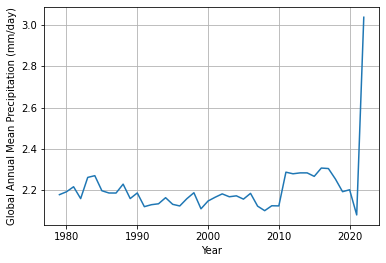

In [3]:
ds3.mean(dim=('lon','lat')).groupby('time.year').mean().precip.plot()
plt.ylabel("Global Annual Mean Precipitation (mm/day)")
plt.xlabel("Year")
plt.grid()

### 3.2 

①Plot the mean precipitation in the lastest month:

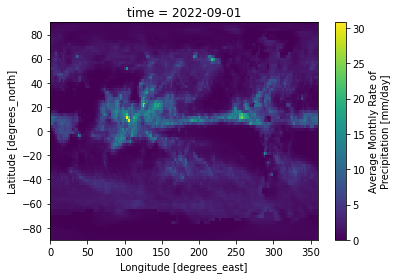

In [4]:
# latest month [-1]
ds3.precip[-1].plot()

②Plot monthly climatology, one at a panel:

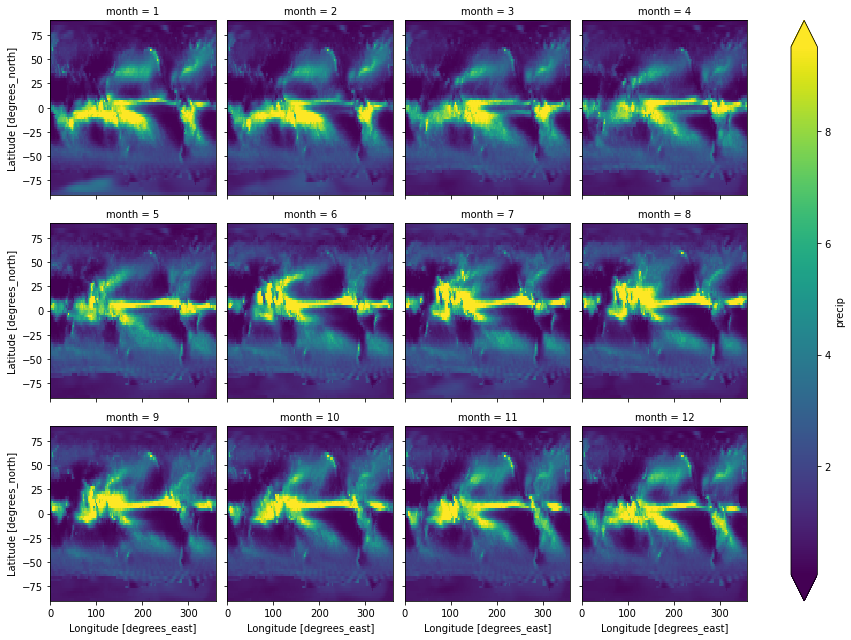

In [6]:
#按月度统计，
precip_clim = ds3.groupby('time.month').mean()

# Plot monthly mean, one at a panel
precip_clim.precip.plot(col="month", col_wrap=4, robust=True)


③Plot climatology in Shenzhen:

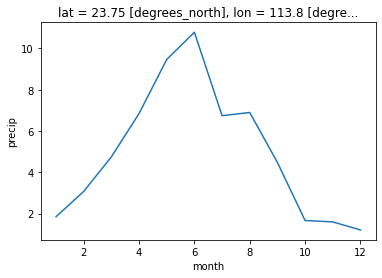

In [8]:
# a specific point (South China Sea)
precip_clim.sel(lon=114.03, lat=22.54, method='nearest').precip.plot()

④ Plot the zonal mean climatology：

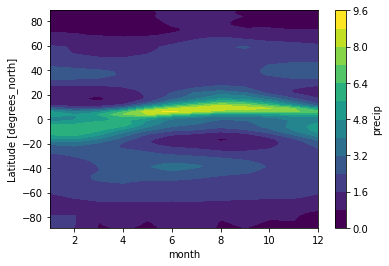

In [11]:
precip_clim.precip.mean(dim='lon').plot.contourf(x='month',levels=12)

⑤Plot the seasonal climatology, one at a panel.

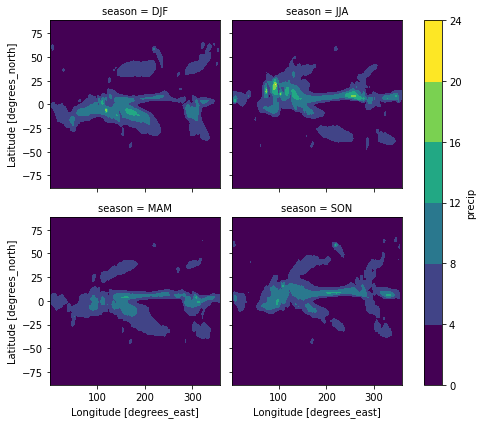

In [12]:
#按季度统计，
precip_clim2 = ds3.groupby('time.season').mean(dim='time')

# Plot monthly mean, one at a panel
precip_clim2.precip.plot.contourf(col="season", col_wrap=2)


⑥Plot the precipitation data onto the earth, and define its projection together with ocean mask.

Text(0.5, 1.0, 'Applying ocean mask on the precipitation data')

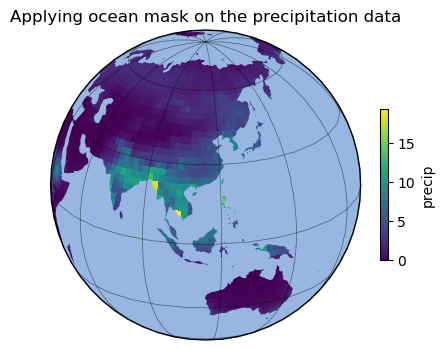

In [24]:
# Create and define the size of a figure object 
plt.figure(figsize=(5,5), dpi=100)

# Create an axes with Orthographic projection style
central_lon, central_lat = 114.06, 22.54 # Shenzhen
proj = ccrs.Orthographic(central_lon, central_lat) 
ax = plt.axes(projection=proj)

# Plot the surface temperature
precip_clim.precip.sel(month=8).plot(ax=ax, transform=ccrs.PlateCarree(),
         cbar_kwargs={'shrink': 0.4})



# Add lat/lon gridlines, draw gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5)

# Manipulate latitude and longitude gridline numbers and spacing
gl.ylocator = mticker.FixedLocator(np.arange(-90,91,30))
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))

# Mask ocean data by adding ocean feature and changing its zorder
ax.add_feature(cfeature.OCEAN, zorder=1)
plt.title("Applying ocean mask on the precipitation data")